In [ ]:
#데이터 전처리 코드

In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import glob
from tqdm import tqdm
import joblib
import re

# tqdm 스타일 설정
tqdm.pandas()

# 파일 경로 설정
nodes_path = r"D:/바탕 화면/2024_1학기 과제물/SNS수업/팀플/nodes.csv"
links_path_pattern = r"D:/바탕 화면/DSRC/Links/Links_04*.csv"
entry_exit_path_pattern = r"D:/바탕 화면/DSRC/진출진입/entering_04*.csv"

# 노드 데이터 불러오기
print("노드 데이터 로드 중...")
nodes_df = pd.read_csv(nodes_path, encoding='utf-8')

# Links 데이터 불러오기
print("Links 데이터 로드 중...")
links_files = glob.glob(links_path_pattern)
links_files_dict = {f: int(re.search(r'Links_04(\d+).csv', f).group(1)) for f in links_files}

print("Links 파일 목록 및 날짜:", links_files_dict)

train_links_files = [f for f in links_files if links_files_dict[f] <= 22]
val_links_files = [f for f in links_files if links_files_dict[f] > 22]

print("학습용 Links 파일:", train_links_files)
print("검증용 Links 파일:", val_links_files)

if train_links_files:
    links_train_df = pd.concat((pd.read_csv(f, encoding='utf-8') for f in tqdm(train_links_files)), ignore_index=True)
else:
    links_train_df = pd.DataFrame()
    print("학습용 Links 파일이 없습니다.")

if val_links_files:
    links_val_df = pd.concat((pd.read_csv(f, encoding='utf-8') for f in tqdm(val_links_files)), ignore_index=True)
else:
    links_val_df = pd.DataFrame()
    print("검증용 Links 파일이 없습니다.")

# 데이터 샘플링 (70%)
links_train_df = links_train_df.sample(frac=0.7, random_state=42)
links_val_df = links_val_df.sample(frac=0.7, random_state=42)

# Entering 데이터 불러오기
print("Entering 데이터 로드 중...")
entry_exit_files = glob.glob(entry_exit_path_pattern)
entry_exit_files_dict = {f: int(re.search(r'entering_04(\d+).csv', f).group(1)) for f in entry_exit_files}

print("Entering 파일 목록 및 날짜:", entry_exit_files_dict)

train_entry_exit_files = [f for f in entry_exit_files if entry_exit_files_dict[f] <= 22]
val_entry_exit_files = [f for f in entry_exit_files if entry_exit_files_dict[f] > 22]

print("학습용 Entering 파일:", train_entry_exit_files)
print("검증용 Entering 파일:", val_entry_exit_files)

if train_entry_exit_files:
    entry_exit_train_df = pd.concat((pd.read_csv(f, encoding='utf-8') for f in tqdm(train_entry_exit_files)), ignore_index=True)
else:
    entry_exit_train_df = pd.DataFrame()
    print("학습용 Entering 파일이 없습니다.")

if val_entry_exit_files:
    entry_exit_val_df = pd.concat((pd.read_csv(f, encoding='utf-8') for f in tqdm(val_entry_exit_files)), ignore_index=True)
else:
    entry_exit_val_df = pd.DataFrame()
    print("검증용 Entering 파일이 없습니다.")

# 데이터 샘플링 (70%)
entry_exit_train_df = entry_exit_train_df.sample(frac=0.7, random_state=42)
entry_exit_val_df = entry_exit_val_df.sample(frac=0.7, random_state=42)

# 각 데이터프레임의 첫 몇 행을 확인
print("Nodes DataFrame:")
display(nodes_df.head())

print("\nLinks Train DataFrame:")
if not links_train_df.empty:
    display(links_train_df.head())
else:
    print("Links Train DataFrame이 비어 있습니다.")

print("\nLinks Validation DataFrame:")
if not links_val_df.empty:
    display(links_val_df.head())
else:
    print("Links Validation DataFrame이 비어 있습니다.")

print("\nEntering Train DataFrame:")
if not entry_exit_train_df.empty:
    display(entry_exit_train_df.head())
else:
    print("Entering Train DataFrame이 비어 있습니다.")

print("\nEntering Validation DataFrame:")
if not entry_exit_val_df.empty:
    display(entry_exit_val_df.head())
else:
    print("Entering Validation DataFrame이 비어 있습니다.")

# 차량 경로 시퀀스 생성
print("차량 경로 시퀀스 생성 중...")
def create_vehicle_paths(links_df):
    vehicle_paths = defaultdict(list)
    for _, row in tqdm(links_df.iterrows(), total=links_df.shape[0]):
        vehicle_paths[row['차량ID']].append(row['Source'])
        vehicle_paths[row['차량ID']].append(row['Target'])
    for vehicle_id in vehicle_paths:
        vehicle_paths[vehicle_id] = list(dict.fromkeys(vehicle_paths[vehicle_id]))
    return vehicle_paths

train_vehicle_paths = create_vehicle_paths(links_train_df)
val_vehicle_paths = create_vehicle_paths(links_val_df)

def create_sequence_df(vehicle_paths):
    sequence_data = []
    for vehicle_id, path in vehicle_paths.items():
        for i in range(len(path) - 1):
            sequence_data.append([vehicle_id, path[i], path[i + 1]])
    return pd.DataFrame(sequence_data, columns=['차량ID', 'Source', 'Target'])

train_sequence_df = create_sequence_df(train_vehicle_paths)
val_sequence_df = create_sequence_df(val_vehicle_paths)

print("\nTrain Sequence DataFrame:")
display(train_sequence_df.head())

print("\nValidation Sequence DataFrame:")
display(val_sequence_df.head())

# 노드 ID에 라벨 인코딩 적용
print("노드 ID 라벨 인코딩 중...")
label_encoder = LabelEncoder()
all_nodes = pd.concat([train_sequence_df['Source'], train_sequence_df['Target'], val_sequence_df['Source'], val_sequence_df['Target']])
label_encoder.fit(all_nodes)

train_sequence_df['Source'] = label_encoder.transform(train_sequence_df['Source'])
train_sequence_df['Target'] = label_encoder.transform(train_sequence_df['Target'])

val_sequence_df['Source'] = label_encoder.transform(val_sequence_df['Source'])
val_sequence_df['Target'] = label_encoder.transform(val_sequence_df['Target'])

# 시퀀스와 레이블 생성
def create_sequences_and_labels(sequence_df):
    sequences = []
    next_nodes = []
    for vehicle_id, group in sequence_df.groupby('차량ID'):
        seq = group['Source'].tolist()
        target = group['Target'].tolist()
        for i in range(1, len(seq)):
            sequences.append(seq[:i])
            next_nodes.append(target[i-1])
    return sequences, next_nodes

train_sequences, train_next_nodes = create_sequences_and_labels(train_sequence_df)
val_sequences, val_next_nodes = create_sequences_and_labels(val_sequence_df)

# 시퀀스 패딩 처리
print("시퀀스 패딩 처리 중...")
max_sequence_length = max(max(len(seq) for seq in train_sequences), max(len(seq) for seq in val_sequences))
train_sequences_padded = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='pre')
val_sequences_padded = pad_sequences(val_sequences, maxlen=max_sequence_length, padding='pre')

# 레이블을 카테고리형으로 변환
train_next_nodes_categorical = to_categorical(train_next_nodes, num_classes=len(label_encoder.classes_))
val_next_nodes_categorical = to_categorical(val_next_nodes, num_classes=len(label_encoder.classes_))

# Entering 데이터도 인코딩
print("Entering 데이터 인코딩 중...")
entry_exit_train_df['RSE_ID'] = label_encoder.transform(entry_exit_train_df['RSE_ID'])
entry_exit_val_df['RSE_ID'] = label_encoder.transform(entry_exit_val_df['RSE_ID'])

# 각 시퀀스에 해당하는 진입/진출 데이터를 반복하여 맞추기
def map_entry_exit_data(sequence_df, entry_exit_df):
    entry_exit_data_dict = entry_exit_df.drop_duplicates(subset=['RSE_ID']).set_index('RSE_ID')[['EnteringCount', 'ExitingCount']].to_dict('index')
    entry_exit_data = [entry_exit_data_dict[node] if node in entry_exit_data_dict else {'EnteringCount': 0, 'ExitingCount': 0} for node in sequence_df['Source']]
    return pd.DataFrame(entry_exit_data).astype(np.float32)

train_entry_exit_data = map_entry_exit_data(train_sequence_df, entry_exit_train_df)
val_entry_exit_data = map_entry_exit_data(val_sequence_df, entry_exit_val_df)

# 데이터 저장
print("데이터 저장 중...")
joblib.dump((train_sequences_padded, train_entry_exit_data, train_next_nodes_categorical, max_sequence_length, label_encoder), 'preprocessed_train_data.pkl')
joblib.dump((val_sequences_padded, val_entry_exit_data, val_next_nodes_categorical, max_sequence_length, label_encoder), 'preprocessed_val_data.pkl')
print("데이터 저장 완료")


In [ ]:
#모델 학습 및 생성 코드 Part 1

Num GPUs Available:  1
데이터 로드 중...
Batch size is consistent across all data batches.
Training sequences - min: 86, max: 86, mean: 86.0
Validation sequences - min: 86, max: 86, mean: 86.0
Padding is consistent across all data batches.
LSTM 모델 생성 중...
Epoch 1/2


100%|████████████████████████████████████████████████████████████████████████| 249212/249212 [4:09:34<00:00, 16.64it/s]


Validation Loss: 583.8917236328125, Validation Accuracy: 0.004627195652574301
Epoch 2/2


100%|████████████████████████████████████████████████████████████████████████| 249212/249212 [4:11:49<00:00, 16.49it/s]


Validation Loss: 626.6820068359375, Validation Accuracy: 0.02366810292005539


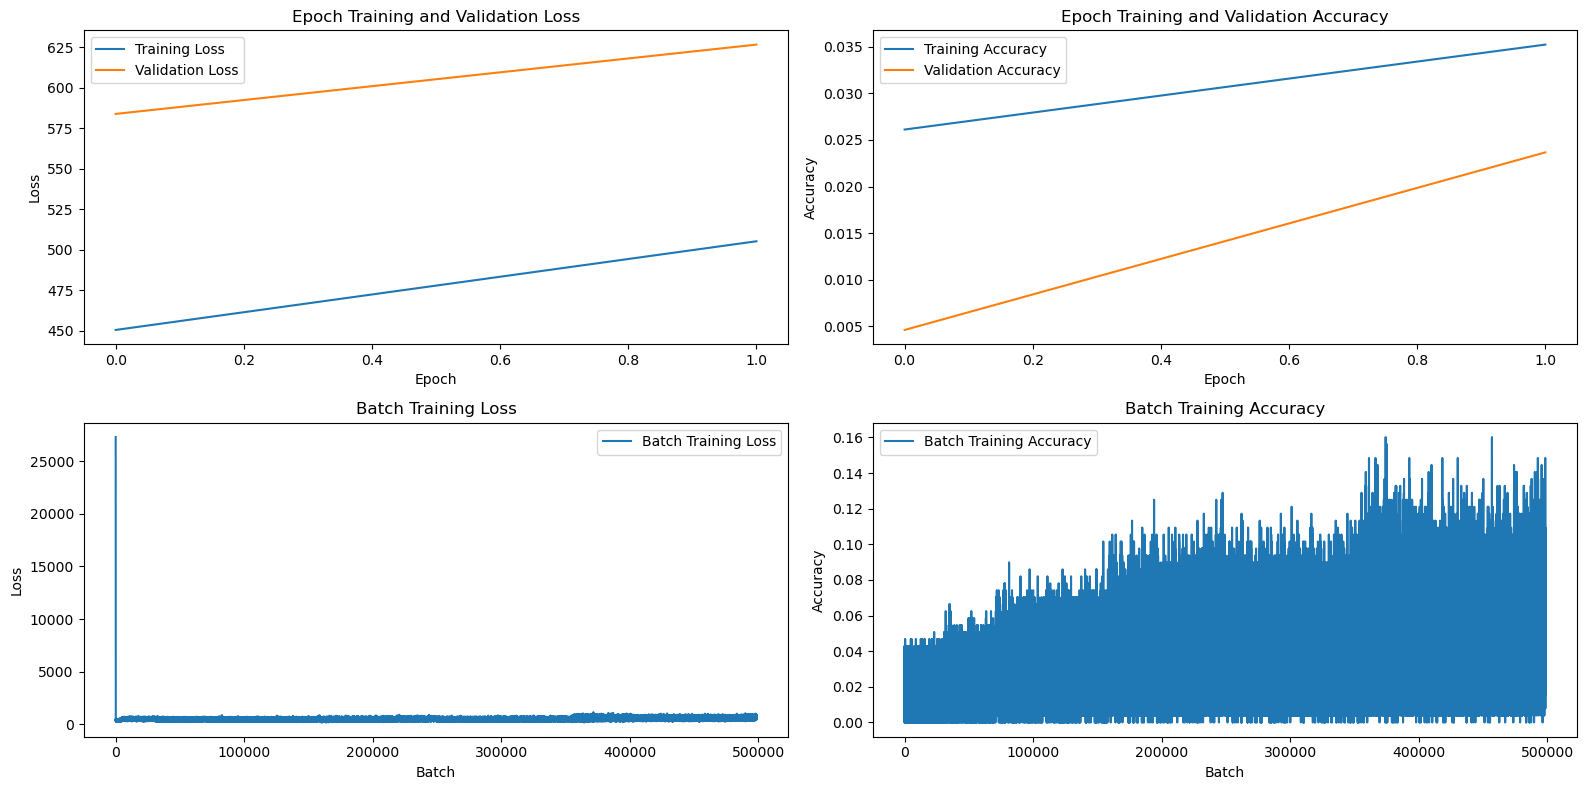

Final Training Loss: 505.2538138319894
Final Training Accuracy: 0.035222760265352815
Final Validation Loss: 626.6820068359375
Final Validation Accuracy: 0.02366810292005539
모델이 'trained_lstm_model.h5'에 저장되었습니다.


In [1]:
import joblib
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Concatenate, Input, Masking, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import os

# GPU 사용 가능 여부 출력
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# GPU 메모리 증가 방식 설정 (선택 사항)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# 데이터 로드 함수 정의
def load_data_in_batches(file_path, batch_size=10000):
    seq_lengths = []
    label_encoders = []
    valid_batches = []
    with open(file_path, 'rb') as f:
        while True:
            try:
                data = joblib.load(f)
                if isinstance(data, tuple):
                    sequences, entry_exit, labels = data[:3]
                    seq_lengths.append(data[3])
                    label_encoders.append(data[4])

                    min_length = min(len(sequences), len(entry_exit), len(labels))
                    sequences = sequences[:min_length]
                    entry_exit = entry_exit[:min_length]
                    labels = labels[:min_length]

                    valid_batches.append((sequences, entry_exit, labels))
            except EOFError:
                break
    joblib.dump(seq_lengths, 'seq_lengths.pkl')
    joblib.dump(label_encoders, 'label_encoders.pkl')
    return valid_batches

# 데이터 로드
print("데이터 로드 중...")
train_batches = list(load_data_in_batches('preprocessed_train_data.pkl'))
val_batches = list(load_data_in_batches('preprocessed_val_data.pkl'))

# 데이터 배치 크기 설정
batch_size = 256

# 배치 크기 일관성 검사 함수
def check_batch_consistency(batches, batch_size):
    for batch in batches:
        sequences, entry_exit, labels = batch
        for start in range(0, len(sequences), batch_size):
            end = start + batch_size
            batch_sequences = sequences[start:end]
            batch_entry_exit = entry_exit[start:end]
            batch_labels = labels[start:end]

            if len(batch_sequences) != len(batch_entry_exit) or len(batch_sequences) != len(batch_labels):
                print(f"Batch size inconsistency detected: Sequences={len(batch_sequences)}, Entry/Exit={len(batch_entry_exit)}, Labels={len(batch_labels)}")
                return False
    return True

# 배치 크기 일관성 검사 실행
train_consistent = check_batch_consistency(train_batches, batch_size)
val_consistent = check_batch_consistency(val_batches, batch_size)

if train_consistent and val_consistent:
    print("Batch size is consistent across all data batches.")
else:
    print("Batch size inconsistency detected. Please check the data preprocessing steps.")

# 시퀀스 길이 통계 확인
def sequence_length_statistics(batches):
    all_lengths = []
    for batch in batches:
        sequences, entry_exit, labels = batch
        batch_lengths = [len(seq) for seq in sequences]
        all_lengths.extend(batch_lengths)
    return all_lengths

train_lengths = sequence_length_statistics(train_batches)
val_lengths = sequence_length_statistics(val_batches)

print(f"Training sequences - min: {min(train_lengths)}, max: {max(train_lengths)}, mean: {np.mean(train_lengths)}")
print(f"Validation sequences - min: {min(val_lengths)}, max: {max(val_lengths)}, mean: {np.mean(val_lengths)}")

# 패딩 확인
def check_padding(batches, padding_value=0):
    for batch in batches:
        sequences, entry_exit, labels = batch
        padded_sequences = pad_sequences(sequences, padding='post', value=padding_value)
        for seq in padded_sequences:
            if len(seq) != len(padded_sequences[0]):
                print(f"Inconsistent padding detected in sequence: {seq}")
                return False
    return True

train_padding_consistent = check_padding(train_batches)
val_padding_consistent = check_padding(val_batches)

if train_padding_consistent and val_padding_consistent:
    print("Padding is consistent across all data batches.")
else:
    print("Inconsistent padding detected. Please check the data preprocessing steps.")

# 모델 정의 함수
def create_model(input_shape, num_classes):
    embedding_dim = 128
    lstm_units = 64
    l2_lambda = 0.01

    node_input = Input(shape=input_shape, name='node_input')
    entry_exit_input = Input(shape=(2,), name='entry_exit_input')

    masking_layer = Masking(mask_value=0.0)(node_input)  # 패딩 값이 0일 경우 마스킹 처리
    embedding_layer = Embedding(input_dim=num_classes, output_dim=embedding_dim)(masking_layer)
    lstm_layer = LSTM(units=lstm_units, return_sequences=False, kernel_regularizer=l2(l2_lambda))(embedding_layer)
    dropout_layer = Dropout(0.5)(lstm_layer)  # 드롭아웃 레이어 추가

    merged_layer = Concatenate()([dropout_layer, entry_exit_input])
    output_layer = Dense(units=num_classes, activation='softmax', kernel_regularizer=l2(l2_lambda))(merged_layer)

    model = Model(inputs=[node_input, entry_exit_input], outputs=output_layer)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# 모델 생성
print("LSTM 모델 생성 중...")
input_shape = (None,)  # 시퀀스의 길이는 None으로 설정
label_encoders = joblib.load('label_encoders.pkl')
num_classes = len(label_encoders[0].classes_)
model = create_model(input_shape, num_classes)

# 조기 종료 및 학습률 조정 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001)

# 학습 기록 저장용 변수 초기화
history = {
    'loss': [],
    'accuracy': [],
    'val_loss': [],
    'val_accuracy': [],
    'batch_loss': [],
    'batch_accuracy': []
}

# 모델 학습
num_epochs = 2  # 에폭 수를 늘림
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    epoch_loss = []
    epoch_accuracy = []
    
    for train_batch in train_batches:
        train_sequences_padded, train_entry_exit_data, train_next_nodes_categorical = train_batch
        
        for start in tqdm(range(0, len(train_sequences_padded), batch_size)):
            end = start + batch_size
            batch_sequences = pad_sequences(train_sequences_padded[start:end], padding='post')
            batch_entry_exit = train_entry_exit_data[start:end]  # 패딩 불필요
            batch_labels = train_next_nodes_categorical[start:end]
            
            if len(batch_sequences) != len(batch_entry_exit) or len(batch_sequences) != len(batch_labels):
                print(f"Skipping batch due to inconsistent sizes: Sequences={len(batch_sequences)}, Entry/Exit={len(batch_entry_exit)}, Labels={len(batch_labels)}")
                continue

            hist = model.fit([batch_sequences, batch_entry_exit], batch_labels, verbose=0, shuffle=False)
            epoch_loss.append(hist.history['loss'][0])
            epoch_accuracy.append(hist.history['accuracy'][0])
            history['batch_loss'].append(hist.history['loss'][0])
            history['batch_accuracy'].append(hist.history['accuracy'][0])
    
    history['loss'].append(np.mean(epoch_loss))
    history['accuracy'].append(np.mean(epoch_accuracy))
    
    val_loss = []
    val_accuracy = []
    for val_batch in val_batches:
        val_sequences_padded, val_entry_exit_data, val_next_nodes_categorical = val_batch

        val_sequences_padded = pad_sequences(val_sequences_padded, padding='post')
        val_entry_exit_data = val_entry_exit_data  # 패딩 불필요
        val_next_nodes_categorical = val_next_nodes_categorical

        val_hist = model.evaluate([val_sequences_padded, val_entry_exit_data], val_next_nodes_categorical, verbose=0)
        val_loss.append(val_hist[0])
        val_accuracy.append(val_hist[1])

    history['val_loss'].append(np.mean(val_loss))
    history['val_accuracy'].append(np.mean(val_accuracy))

    print(f"Validation Loss: {history['val_loss'][-1]}, Validation Accuracy: {history['val_accuracy'][-1]}")

# 학습 기록 시각화
plt.figure(figsize=(16, 8))

# 에폭 단위 손실 그래프
plt.subplot(2, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch Training and Validation Loss')
plt.legend()

# 에폭 단위 정확도 그래프
plt.subplot(2, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch Training and Validation Accuracy')
plt.legend()

# 배치 단위 손실 그래프
plt.subplot(2, 2, 3)
plt.plot(history['batch_loss'], label='Batch Training Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Batch Training Loss')
plt.legend()

# 배치 단위 정확도 그래프
plt.subplot(2, 2, 4)
plt.plot(history['batch_accuracy'], label='Batch Training Accuracy')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.title('Batch Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# 최종 학습 및 검증 손실과 정확도 출력
print(f"Final Training Loss: {history['loss'][-1]}")
print(f"Final Training Accuracy: {history['accuracy'][-1]}")
print(f"Final Validation Loss: {history['val_loss'][-1]}")
print(f"Final Validation Accuracy: {history['val_accuracy'][-1]}")

# 모델 저장
model.save('trained_lstm_model.h5')
print("모델이 'trained_lstm_model.h5'에 저장되었습니다.")


In [ ]:
#누적 학습 코드

In [1]:
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import tensorflow as tf

# GPU 사용 가능 여부 출력
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# GPU 메모리 증가 방식 설정 (선택 사항)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# 데이터 로드 함수 정의
def load_data_in_batches(file_path, batch_size=10000):
    seq_lengths = []
    label_encoders = []
    valid_batches = []
    with open(file_path, 'rb') as f:
        while True:
            try:
                data = joblib.load(f)
                if isinstance(data, tuple):
                    sequences, entry_exit, labels = data[:3]
                    seq_lengths.append(data[3])
                    label_encoders.append(data[4])

                    min_length = min(len(sequences), len(entry_exit), len(labels))
                    sequences = sequences[:min_length]
                    entry_exit = entry_exit[:min_length]
                    labels = labels[:min_length]

                    valid_batches.append((sequences, entry_exit, labels))
            except EOFError:
                break
    return valid_batches

# 데이터 로드
print("데이터 로드 중...")
val_batches = list(load_data_in_batches('preprocessed_val_data.pkl'))

# 모델 불러오기
model = load_model('trained_lstm_model.h5')

# 조기 종료 및 학습률 조정 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001)

# 학습 기록 저장용 변수 초기화
history = {
    'loss': [],
    'accuracy': [],
    'val_loss': [],
    'val_accuracy': [],
    'batch_loss': [],
    'batch_accuracy': []
}

# 데이터 로드
print("데이터 로드 중...")
train_batches = list(load_data_in_batches('preprocessed_train_data.pkl'))

# 추가적인 학습
num_epochs = 2
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    epoch_loss = []
    epoch_accuracy = []

    for train_batch in train_batches:
        train_sequences_padded, train_entry_exit_data, train_next_nodes_categorical = train_batch

        for start in tqdm(range(0, len(train_sequences_padded), batch_size)):
            end = start + batch_size
            batch_sequences = pad_sequences(train_sequences_padded[start:end], padding='post')
            batch_entry_exit = train_entry_exit_data[start:end]  # 패딩 불필요
            batch_labels = train_next_nodes_categorical[start:end]

            if len(batch_sequences) != len(batch_entry_exit) or len(batch_sequences) != len(batch_labels):
                print(f"Skipping batch due to inconsistent sizes: Sequences={len(batch_sequences)}, Entry/Exit={len(batch_entry_exit)}, Labels={len(batch_labels)}")
                continue

            hist = model.fit([batch_sequences, batch_entry_exit], batch_labels, verbose=0, shuffle=False)
            epoch_loss.append(hist.history['loss'][0])
            epoch_accuracy.append(hist.history['accuracy'][0])
            history['batch_loss'].append(hist.history['loss'][0])
            history['batch_accuracy'].append(hist.history['accuracy'][0])

    history['loss'].append(np.mean(epoch_loss))
    history['accuracy'].append(np.mean(epoch_accuracy))

    val_loss = []
    val_accuracy = []
    for val_batch in val_batches:
        val_sequences_padded, val_entry_exit_data, val_next_nodes_categorical = val_batch

        val_sequences_padded = pad_sequences(val_sequences_padded, padding='post')
        val_entry_exit_data = val_entry_exit_data  # 패딩 불필요
        val_next_nodes_categorical = val_next_nodes_categorical

        val_hist = model.evaluate([val_sequences_padded, val_entry_exit_data], val_next_nodes_categorical, verbose=0)
        val_loss.append(val_hist[0])
        val_accuracy.append(val_hist[1])

    history['val_loss'].append(np.mean(val_loss))
    history['val_accuracy'].append(np.mean(val_accuracy))

    print(f"Validation Loss: {history['val_loss'][-1]}, Validation Accuracy: {history['val_accuracy'][-1]}")

# 학습 기록 시각화
plt.figure(figsize=(16, 8))

# 에폭 단위 손실 그래프
plt.subplot(2, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch Training and Validation Loss')
plt.legend()

# 에폭 단위 정확도 그래프
plt.subplot(2, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch Training and Validation Accuracy')
plt.legend()

# 배치 단위 손실 그래프
plt.subplot(2, 2, 3)
plt.plot(history['batch_loss'], label='Batch Training Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Batch Training Loss')
plt.legend()

# 배치 단위 정확도 그래프
plt.subplot(2, 2, 4)
plt.plot(history['batch_accuracy'], label='Batch Training Accuracy')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.title('Batch Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# 최종 학습 및 검증 손실과 정확도 출력
print(f"Final Training Loss: {history['loss'][-1]}")
print(f"Final Training Accuracy: {history['accuracy'][-1]}")
print(f"Final Validation Loss: {history['val_loss'][-1]}")
print(f"Final Validation Accuracy: {history['val_accuracy'][-1]}")

# 모델 저장
model.save('trained_lstm_model.h5')
print("모델이 'trained_lstm_model.h5'에 저장되었습니다.")


Num GPUs Available:  1
데이터 로드 중...


KeyboardInterrupt: 

In [ ]:
#예측 코드 GPU Part 1(Entering.csv + Link..csv로 예측), 전체데이터

In [3]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import joblib
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
from datetime import datetime, timedelta
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
import re
import os

# GPU 설정 확인
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if tf.config.list_physical_devices('GPU'):
    for gpu in tf.config.list_physical_devices('GPU'):
        tf.config.experimental.set_memory_growth(gpu, True)

# 모델 로드
model = load_model('trained_lstm_model.h5')
label_encoders = joblib.load('label_encoders.pkl')

# 검증 데이터 로드 함수 정의
def load_data_in_batches(file_path, batch_size=10000):
    valid_batches = []
    with open(file_path, 'rb') as f:
        while True:
            try:
                data = joblib.load(f)
                if isinstance(data, tuple):
                    sequences, entry_exit, labels = data[:3]
                    
                    min_length = min(len(sequences), len(entry_exit), len(labels))
                    sequences = sequences[:min_length]
                    entry_exit = entry_exit[:min_length]
                    labels = labels[:min_length]

                    valid_batches.append((sequences, entry_exit, labels))
            except EOFError:
                break
    return valid_batches

# 링크 파일 로드 함수 정의
def load_links_files(links_path_pattern):
    links_files = glob.glob(links_path_pattern)
    links_files_dict = {f: int(re.search(r'Links_04(\d+).csv', f).group(1)) for f in links_files}
    val_links_files = [f for f in links_files if links_files_dict[f] > 22]

    if val_links_files:
        links_val_df = pd.concat((pd.read_csv(f, encoding='utf-8-sig') for f in val_links_files), ignore_index=True)
    else:
        links_val_df = pd.DataFrame()
        print("검증용 Links 파일이 없습니다.")

    return links_val_df

# 차량 경로 시퀀스 생성
def create_vehicle_paths(links_df):
    vehicle_paths = defaultdict(list)
    for _, row in tqdm(links_df.iterrows(), total=links_df.shape[0]):
        vehicle_paths[row['차량ID']].append(row['Source'])
        vehicle_paths[row['차량ID']].append(row['Target'])
    for vehicle_id in vehicle_paths:
        vehicle_paths[vehicle_id] = list(dict.fromkeys(vehicle_paths[vehicle_id]))
    return vehicle_paths

def create_sequence_df(vehicle_paths):
    sequence_data = []
    for vehicle_id, path in vehicle_paths.items():
        for i in range(len(path) - 1):
            sequence_data.append([vehicle_id, path[i], path[i + 1]])
    return pd.DataFrame(sequence_data, columns=['차량ID', 'Source', 'Target'])

# 예측 수행
print("데이터 로드 중...")
val_batches = list(load_data_in_batches('preprocessed_val_data.pkl'))

# 링크 데이터 로드
links_path_pattern = r"D:/바탕 화면/DSRC/Links/Links_04*.csv"
links_val_df = load_links_files(links_path_pattern)

# 차량 경로 시퀀스 생성
val_vehicle_paths = create_vehicle_paths(links_val_df)
val_sequence_df = create_sequence_df(val_vehicle_paths)

# 노드 ID에 라벨 인코딩 적용
try:
    val_sequence_df['Source'] = label_encoders[0].transform(val_sequence_df['Source'])
    val_sequence_df['Target'] = label_encoders[0].transform(val_sequence_df['Target'])
except Exception as e:
    print(f"Label encoding error: {e}")
    raise

# 시퀀스와 레이블 생성
def create_sequences(sequence_df):
    sequences = []
    for vehicle_id, group in sequence_df.groupby('차량ID'):
        seq = group['Source'].tolist()
        for i in range(1, len(seq)):
            sequences.append(seq[:i])
    return sequences

val_sequences = create_sequences(val_sequence_df)

# 시퀀스 패딩 처리
print("시퀀스 패딩 처리 중...")
try:
    max_sequence_length = max(len(seq) for seq in val_sequences)
    val_sequences_padded = pad_sequences(val_sequences, maxlen=max_sequence_length, padding='pre')
except Exception as e:
    print(f"Sequence padding error: {e}")
    raise

# 진입/진출 데이터 로드 및 필터링
def load_filtered_entry_exit_data(entry_exit_path_pattern, start_date, end_date):
    entry_exit_files = glob.glob(entry_exit_path_pattern)
    print("All entry/exit files:", entry_exit_files)  # 파일 리스트 출력
    filtered_files = []
    for f in entry_exit_files:
        file_name = os.path.basename(f)
        print(f"Processing file: {file_name}")  # 파일 이름 출력
        match = re.search(r'entering_04(\d{2}).csv', file_name)
        if match:
            file_date = datetime(2024, 4, int(match.group(1))).date() # 2024년 4월로 고정하여 날짜 생성
            if start_date <= file_date <= end_date:
                filtered_files.append(f)
    print("Filtered entry/exit files:", filtered_files)  # 필터링된 파일 리스트 출력
    if filtered_files:
        entry_exit_df = pd.concat((pd.read_csv(f, encoding='utf-8-sig') for f in filtered_files), ignore_index=True)
    else:
        raise ValueError("No entry/exit files found for the specified date range.")
    return entry_exit_df

start_date = datetime(2024, 4, 23).date()
end_date = datetime(2024, 4, 30).date()

try:
    entry_exit_val_df = load_filtered_entry_exit_data('D:/바탕 화면/DSRC/진출진입/entering_04*.csv', start_date, end_date)
except ValueError as e:
    print(e)
    raise

try:
    entry_exit_val_df['RSE_ID'] = label_encoders[0].transform(entry_exit_val_df['RSE_ID'])
    val_entry_exit_data = pd.DataFrame(entry_exit_val_df.groupby('RSE_ID')[['EnteringCount', 'ExitingCount']].sum()).reindex(val_sequence_df['Source']).fillna(0).values
except KeyError as e:
    print(f"Key error: {e}")
    raise

# 날짜 범위 설정
start_date = datetime(2024, 4, 23)
end_date = datetime(2024, 4, 30)
date_range = pd.date_range(start=start_date, end=end_date)

# 예측 결과 저장을 위한 데이터프레임 생성
all_predictions = []

for current_date in date_range:
    print(f"{current_date.strftime('%Y-%m-%d')} 예측 수행 중...")
    
    # 각 날별 예측을 위한 데이터 준비
    # tqdm을 사용하여 예측 과정 시각화
    predictions = np.zeros((val_sequences_padded.shape[0], len(label_encoders[0].classes_)))
    for i in tqdm(range(0, val_sequences_padded.shape[0], 256), desc="Prediction Progress"):
        batch_sequences = val_sequences_padded[i:i + 256]
        batch_entry_exit = val_entry_exit_data[i:i + 256]

        # 배치 크기를 맞춤
        min_batch_size = min(len(batch_sequences), len(batch_entry_exit))
        batch_sequences = batch_sequences[:min_batch_size]
        batch_entry_exit = batch_entry_exit[:min_batch_size]

        # 배치 크기가 동일하지 않으면 건너뜀
        if len(batch_sequences) != len(batch_entry_exit):
            print(f"Skipping batch at index {i} due to size mismatch: {len(batch_sequences)} sequences and {len(batch_entry_exit)} entry/exit data")
            continue

        try:
            predictions[i:i + min_batch_size] = model.predict([batch_sequences, batch_entry_exit], verbose=0)[:min_batch_size]
        except Exception as e:
            print(f"Prediction error at batch {i}: {e}")
            raise

    # 각 시퀀스에 대해 가장 높은 확률을 가진 노드 인덱스 가져오기
    try:
        predicted_nodes = predictions.argmax(axis=1)
        predicted_node_ids = label_encoders[0].inverse_transform(predicted_nodes)
    except Exception as e:
        print(f"Error during prediction post-processing: {e}")
        raise

    # 각 예측된 노드의 발생 빈도 계산
    node_counts = pd.Series(predicted_node_ids).value_counts()

    # 가장 혼잡한 노드 상위 8개 추출
    congested_nodes = node_counts.head(8)
    print(f"Top 8 most congested nodes for {current_date.strftime('%Y-%m-%d')}:")
    print(congested_nodes)

    # 예측된 혼잡 노드 정보를 추출
    congested_nodes_df = pd.DataFrame({
        'Date': current_date.strftime('%Y-%m-%d'),
        'Node': congested_nodes.index,
        'PredictedCount': congested_nodes.values
    }).reset_index(drop=True)  # 인덱스를 0부터 시작하도록 재설정

    all_predictions.append(congested_nodes_df)

# 모든 예측 결과를 하나의 데이터프레임으로 결합
final_predictions_df = pd.concat(all_predictions)

# 기존 데이터프레임에서 주소 정보 가져오기
entry_exit_files = glob.glob('D:/바탕 화면/DSRC/진출진입/entering_04*.csv')
try:
    entry_exit_dfs = []
    for f in entry_exit_files:
        df = pd.read_csv(f, encoding='utf-8-sig')
        df['파일명'] = os.path.basename(f)  # 각 데이터프레임에 파일명을 추가
        entry_exit_dfs.append(df)
    entry_exit_df = pd.concat(entry_exit_dfs, ignore_index=True)

    # 파일 이름에서 날짜를 추출하여 Date 열 생성
    entry_exit_df['Date'] = entry_exit_df['파일명'].apply(lambda x: datetime.strptime(re.search(r'entering_04(\d{2}).csv', x).group(1), '%d').strftime('2024-04-%d'))
    address_mapping = entry_exit_df[['RSE_ID', 'Address']].drop_duplicates().set_index('RSE_ID')
except KeyError as e:
    print(f"Key error: {e}")
    raise

# 주소 정보를 예측된 혼잡 노드 정보와 병합
try:
    final_predictions_df = final_predictions_df.join(address_mapping, on='Node')
except KeyError as e:
    print(f"Key error during merging: {e}")
    raise

# 결과를 CSV 파일로 저장 (한글 인코딩 설정)
final_predictions_df.to_csv('predicted_congested_nodes.csv', index=False, encoding='utf-8-sig')
print("예측된 혼잡 노드 정보를 predicted_congested_nodes.csv 파일로 저장했습니다.")

# 기존 교통량 데이터 로드
existing_traffic_files = []
for day in range(23, 31):
    file_pattern = f'D:/바탕 화면/DSRC/진출진입/entering_04{day:02d}.csv'
    existing_traffic_files.extend(glob.glob(file_pattern))

existing_traffic_df = pd.concat((pd.read_csv(f, encoding='utf-8-sig') for f in existing_traffic_files), ignore_index=True)

# 날짜와 노드를 기준으로 기존 교통량 데이터를 날짜별로 그룹화
existing_traffic_df['Node'] = existing_traffic_df['RSE_ID'].astype(str)
existing_traffic_df['Date'] = pd.to_datetime(existing_traffic_df['Date']).dt.strftime('%Y-%m-%d')

existing_entering_counts = existing_traffic_df.groupby(['Node', 'Date'])['EnteringCount'].sum().reset_index()
existing_exiting_counts = existing_traffic_df.groupby(['Node', 'Date'])['ExitingCount'].sum().reset_index()

existing_congested_df = pd.merge(existing_entering_counts, existing_exiting_counts, on=['Node', 'Date'], how='outer')
existing_congested_df.rename(columns={'EnteringCount': 'ExistingEnteringCount', 'ExitingCount': 'ExistingExitingCount'}, inplace=True)

# 날짜와 요일 추가
existing_congested_df['Date'] = existing_congested_df['Date'].astype(str)

# 데이터 병합
comparison_df = pd.merge(final_predictions_df, existing_congested_df, on=['Node', 'Date'], how='left')

# 정규화
comparison_df['PredictedCount_normalized'] = comparison_df['PredictedCount'] / comparison_df['PredictedCount'].max()
comparison_df['ExistingEnteringCount_normalized'] = comparison_df['ExistingEnteringCount'] / comparison_df['ExistingEnteringCount'].max()
comparison_df['ExistingExitingCount_normalized'] = comparison_df['ExistingExitingCount'] / comparison_df['ExistingExitingCount'].max()

# 비례 변환
max_existing_count = max(comparison_df['ExistingEnteringCount'].max(), comparison_df['ExistingExitingCount'].max())
comparison_df['PredictedCount_scaled'] = comparison_df['PredictedCount'] * (max_existing_count / comparison_df['PredictedCount'].max())

# 그래프 시각화
fig, axes = plt.subplots(4, 6, figsize=(30, 20))
axes = axes.flatten()

for i, date in enumerate(date_range.strftime('%Y-%m-%d')):
    day_data = comparison_df[comparison_df['Date'] == date]
    
    x = np.arange(len(day_data))
    width = 0.3

    # 원본 비교 그래프
    axes[i * 3].bar(x - width, day_data['PredictedCount'], width, label='Predicted Traffic')
    axes[i * 3].bar(x, day_data['ExistingEnteringCount'], width, alpha=0.7, label='Existing Entering Traffic')
    axes[i * 3].bar(x + width, day_data['ExistingExitingCount'], width, alpha=0.7, label='Existing Exiting Traffic')
    axes[i * 3].set_title(f'Traffic Comparison for {date}')
    axes[i * 3].set_xticks(x)
    axes[i * 3].set_xticklabels(day_data['Node'])
    axes[i * 3].set_xlabel('Node')
    axes[i * 3].set_ylabel('Traffic Count')
    axes[i * 3].legend()
    axes[i * 3].set_yticks(np.arange(0, max(day_data[['PredictedCount', 'ExistingEnteringCount', 'ExistingExitingCount']].max()) + 500, 500))

    # 정규화 비교 그래프
    axes[i * 3 + 1].bar(x - width, day_data['PredictedCount_normalized'], width, label='Normalized Predicted Traffic')
    axes[i * 3 + 1].bar(x, day_data['ExistingEnteringCount_normalized'], width, alpha=0.7, label='Normalized Existing Entering Traffic')
    axes[i * 3 + 1].bar(x + width, day_data['ExistingExitingCount_normalized'], width, alpha=0.7, label='Normalized Existing Exiting Traffic')
    axes[i * 3 + 1].set_title(f'Normalized Traffic Comparison for {date}')
    axes[i * 3 + 1].set_xticks(x)
    axes[i * 3 + 1].set_xticklabels(day_data['Node'])
    axes[i * 3 + 1].set_xlabel('Node')
    axes[i * 3 + 1].set_ylabel('Normalized Traffic Count')
    axes[i * 3 + 1].legend()
    axes[i * 3 + 1].set_yticks(np.arange(0, 1.1, 0.1))

    # 비례 변환 비교 그래프
    axes[i * 3 + 2].bar(x - width, day_data['PredictedCount_scaled'], width, label='Scaled Predicted Traffic')
    axes[i * 3 + 2].bar(x, day_data['ExistingEnteringCount'], width, alpha=0.7, label='Existing Entering Traffic')
    axes[i * 3 + 2].bar(x + width, day_data['ExistingExitingCount'], width, alpha=0.7, label='Existing Exiting Traffic')
    axes[i * 3 + 2].set_title(f'Scaled Traffic Comparison for {date}')
    axes[i * 3 + 2].set_xticks(x)
    axes[i * 3 + 2].set_xticklabels(day_data['Node'])
    axes[i * 3 + 2].set_xlabel('Node')
    axes[i * 3 + 2].set_ylabel('Traffic Count')
    axes[i * 3 + 2].legend()
    axes[i * 3 + 2].set_yticks(np.arange(0, max(comparison_df['PredictedCount_scaled'].max(), max_existing_count) + 500, 500))

plt.tight_layout()
plt.show()

Num GPUs Available:  1
데이터 로드 중...


100%|███████████████████████████████████████████████████████████████████| 42498962/42498962 [14:05<00:00, 50287.00it/s]


시퀀스 패딩 처리 중...
All entry/exit files: ['D:/바탕 화면/DSRC/진출진입\\entering_0401.csv', 'D:/바탕 화면/DSRC/진출진입\\entering_0402.csv', 'D:/바탕 화면/DSRC/진출진입\\entering_0403.csv', 'D:/바탕 화면/DSRC/진출진입\\entering_0404.csv', 'D:/바탕 화면/DSRC/진출진입\\entering_0405.csv', 'D:/바탕 화면/DSRC/진출진입\\entering_0406.csv', 'D:/바탕 화면/DSRC/진출진입\\entering_0407.csv', 'D:/바탕 화면/DSRC/진출진입\\entering_0408.csv', 'D:/바탕 화면/DSRC/진출진입\\entering_0409.csv', 'D:/바탕 화면/DSRC/진출진입\\entering_0410.csv', 'D:/바탕 화면/DSRC/진출진입\\entering_0411.csv', 'D:/바탕 화면/DSRC/진출진입\\entering_0412.csv', 'D:/바탕 화면/DSRC/진출진입\\entering_0413.csv', 'D:/바탕 화면/DSRC/진출진입\\entering_0414.csv', 'D:/바탕 화면/DSRC/진출진입\\entering_0415.csv', 'D:/바탕 화면/DSRC/진출진입\\entering_0416.csv', 'D:/바탕 화면/DSRC/진출진입\\entering_0417.csv', 'D:/바탕 화면/DSRC/진출진입\\entering_0418.csv', 'D:/바탕 화면/DSRC/진출진입\\entering_0419.csv', 'D:/바탕 화면/DSRC/진출진입\\entering_0420.csv', 'D:/바탕 화면/DSRC/진출진입\\entering_0421.csv', 'D:/바탕 화면/DSRC/진출진입\\entering_0422.csv', 'D:/바탕 화면/DSRC/진출진입\\entering_0423.csv', 'D:/바탕 화면/DSRC/진출진입

Prediction Progress:  19%|██████████                                            | 19962/106698 [11:23<49:30, 29.20it/s]


KeyboardInterrupt: 

In [ ]:
#예측 코드 GPU Part 1(Entering.csv + Link..csv로 예측), 테스트 데이터

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import joblib
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
from datetime import datetime
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
import re
import os

# GPU 설정 확인
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if tf.config.list_physical_devices('GPU'):
    for gpu in tf.config.list_physical_devices('GPU'):
        tf.config.experimental.set_memory_growth(gpu, True)

# 모델 로드
model = load_model('trained_lstm_model.h5')
label_encoders = joblib.load('label_encoders.pkl')

# 검증 데이터 로드 함수 정의
def load_data_in_batches(file_path, batch_size=10000):
    valid_batches = []
    with open(file_path, 'rb') as f:
        while True:
            try:
                data = joblib.load(f)
                if isinstance(data, tuple):
                    sequences, entry_exit, labels = data[:3]
                    
                    min_length = min(len(sequences), len(entry_exit), len(labels))
                    sequences = sequences[:min_length]
                    entry_exit = entry_exit[:min_length]
                    labels = labels[:min_length]

                    valid_batches.append((sequences, entry_exit, labels))
            except EOFError:
                break
    return valid_batches

# 링크 파일 로드 함수 정의
def load_links_files(links_path_pattern):
    links_files = glob.glob(links_path_pattern)
    links_files_dict = {f: int(re.search(r'Links_04(\d+).csv', f).group(1)) for f in links_files}
    val_links_files = [f for f in links_files if links_files_dict[f] > 22]

    if val_links_files:
        links_val_df = pd.concat((pd.read_csv(f, encoding='utf-8-sig') for f in val_links_files), ignore_index=True)
    else:
        links_val_df = pd.DataFrame()
        print("검증용 Links 파일이 없습니다.")

    return links_val_df

# 차량 경로 시퀀스 생성
def create_vehicle_paths(links_df):
    vehicle_paths = defaultdict(list)
    for _, row in tqdm(links_df.iterrows(), total=links_df.shape[0]):
        vehicle_paths[row['차량ID']].append(row['Source'])
        vehicle_paths[row['차량ID']].append(row['Target'])
    for vehicle_id in vehicle_paths:
        vehicle_paths[vehicle_id] = list(dict.fromkeys(vehicle_paths[vehicle_id]))
    return vehicle_paths

def create_sequence_df(vehicle_paths):
    sequence_data = []
    for vehicle_id, path in vehicle_paths.items():
        for i in range(len(path) - 1):
            sequence_data.append([vehicle_id, path[i], path[i + 1]])
    return pd.DataFrame(sequence_data, columns=['차량ID', 'Source', 'Target'])

# 예측 수행
print("데이터 로드 중...")
val_batches = list(load_data_in_batches('preprocessed_val_data.pkl'))

# 링크 데이터 로드
links_path_pattern = r"D:/바탕 화면/DSRC/Links/Links_04*.csv"
links_val_df = load_links_files(links_path_pattern)

# 차량 경로 시퀀스 생성
val_vehicle_paths = create_vehicle_paths(links_val_df)
val_sequence_df = create_sequence_df(val_vehicle_paths)

# 노드 ID에 라벨 인코딩 적용
try:
    val_sequence_df['Source'] = label_encoders[0].transform(val_sequence_df['Source'])
    val_sequence_df['Target'] = label_encoders[0].transform(val_sequence_df['Target'])
except Exception as e:
    print(f"Label encoding error: {e}")
    raise

# 시퀀스와 레이블 생성
def create_sequences(sequence_df):
    sequences = []
    for vehicle_id, group in sequence_df.groupby('차량ID'):
        seq = group['Source'].tolist()
        for i in range(1, len(seq)):
            sequences.append(seq[:i])
    return sequences

val_sequences = create_sequences(val_sequence_df)

# 시퀀스 패딩 처리
print("시퀀스 패딩 처리 중...")
try:
    max_sequence_length = max(len(seq) for seq in val_sequences)
    val_sequences_padded = pad_sequences(val_sequences, maxlen=max_sequence_length, padding='pre')
except Exception as e:
    print(f"Sequence padding error: {e}")
    raise

# 진입/진출 데이터 로드 및 필터링
def load_filtered_entry_exit_data(entry_exit_path_pattern, start_date, end_date):
    entry_exit_files = glob.glob(entry_exit_path_pattern)
    print("All entry/exit files:", entry_exit_files)  # 파일 리스트 출력
    filtered_files = []
    for f in entry_exit_files:
        file_name = os.path.basename(f)
        print(f"Processing file: {file_name}")  # 파일 이름 출력
        match = re.search(r'entering_04(\d{2}).csv', file_name)
        if match:
            file_date = datetime(2024, 4, int(match.group(1))).date() # 2024년 4월로 고정하여 날짜 생성
            if start_date <= file_date <= end_date:
                filtered_files.append(f)
    print("Filtered entry/exit files:", filtered_files)  # 필터링된 파일 리스트 출력
    if filtered_files:
        entry_exit_df = pd.concat((pd.read_csv(f, encoding='utf-8-sig') for f in filtered_files), ignore_index=True)
    else:
        raise ValueError("No entry/exit files found for the specified date range.")
    return entry_exit_df

start_date = datetime(2024, 4, 23).date()
end_date = datetime(2024, 4, 23).date()  # 4월 23일만 테스트

try:
    entry_exit_val_df = load_filtered_entry_exit_data('D:/바탕 화면/DSRC/진출진입/entering_04*.csv', start_date, end_date)
except ValueError as e:
    print(e)
    raise

try:
    entry_exit_val_df['RSE_ID'] = label_encoders[0].transform(entry_exit_val_df['RSE_ID'])
    val_entry_exit_data = pd.DataFrame(entry_exit_val_df.groupby('RSE_ID')[['EnteringCount', 'ExitingCount']].sum()).reindex(val_sequence_df['Source']).fillna(0).values
except KeyError as e:
    print(f"Key error: {e}")
    raise

# 날짜 범위 설정
date_range = pd.date_range(start=start_date, end=end_date)

# 예측 결과 저장을 위한 데이터프레임 생성
all_predictions = []

for current_date in date_range:
    print(f"{current_date.strftime('%Y-%m-%d')} 예측 수행 중...")
    
    # 각 날별 예측을 위한 데이터 준비
    # tqdm을 사용하여 예측 과정 시각화
    predictions = np.zeros((val_sequences_padded.shape[0], len(label_encoders[0].classes_)))
    for i in tqdm(range(0, val_sequences_padded.shape[0], 256), desc="Prediction Progress"):
        batch_sequences = val_sequences_padded[i:i + 256]
        batch_entry_exit = val_entry_exit_data[i:i + 256]

        # 배치 크기를 맞춤
        min_batch_size = min(len(batch_sequences), len(batch_entry_exit))
        batch_sequences = batch_sequences[:min_batch_size]
        batch_entry_exit = batch_entry_exit[:min_batch_size]

        # 배치 크기가 동일하지 않으면 건너뜀
        if len(batch_sequences) != len(batch_entry_exit):
            print(f"Skipping batch at index {i} due to size mismatch: {len(batch_sequences)} sequences and {len(batch_entry_exit)} entry/exit data")
            continue

        try:
            predictions[i:i + min_batch_size] = model.predict([batch_sequences, batch_entry_exit], verbose=0)[:min_batch_size]
        except Exception as e:
            print(f"Prediction error at batch {i}: {e}")
            raise

    # 각 시퀀스에 대해 가장 높은 확률을 가진 노드 인덱스 가져오기
    try:
        predicted_nodes = predictions.argmax(axis=1)
        predicted_node_ids = label_encoders[0].inverse_transform(predicted_nodes)
    except Exception as e:
        print(f"Error during prediction post-processing: {e}")
        raise

    # 각 예측된 노드의 발생 빈도 계산
    node_counts = pd.Series(predicted_node_ids).value_counts()

    # 가장 혼잡한 노드 상위 8개 추출
    congested_nodes = node_counts.head(8)
    print(f"Top 8 most congested nodes for {current_date.strftime('%Y-%m-%d')}:")
    print(congested_nodes)

    # 예측된 혼잡 노드 정보를 추출
    congested_nodes_df = pd.DataFrame({
        'Date': current_date.strftime('%Y-%m-%d'),
        'Node': congested_nodes.index,
        'PredictedCount': congested_nodes.values
    }).reset_index(drop=True)  # 인덱스를 0부터 시작하도록 재설정

    all_predictions.append(congested_nodes_df)

# 모든 예측 결과를 하나의 데이터프레임으로 결합
final_predictions_df = pd.concat(all_predictions)

# 기존 데이터프레임에서 주소 정보 가져오기
entry_exit_files = glob.glob('D:/바탕 화면/DSRC/진출진입/entering_04*.csv')
try:
    entry_exit_dfs = []
    for f in entry_exit_files:
        df = pd.read_csv(f, encoding='utf-8-sig')
        df['파일명'] = os.path.basename(f)  # 각 데이터프레임에 파일명을 추가
        entry_exit_dfs.append(df)
    entry_exit_df = pd.concat(entry_exit_dfs, ignore_index=True)

    # 파일 이름에서 날짜를 추출하여 Date 열 생성
    entry_exit_df['Date'] = entry_exit_df['파일명'].apply(lambda x: datetime.strptime(re.search(r'entering_04(\d{2}).csv', x).group(1), '%d').strftime('2024-04-%d'))
    address_mapping = entry_exit_df[['RSE_ID', 'Address']].drop_duplicates().set_index('RSE_ID')
except KeyError as e:
    print(f"Key error: {e}")
    raise

# 주소 정보를 예측된 혼잡 노드 정보와 병합
try:
    final_predictions_df = final_predictions_df.join(address_mapping, on='Node')
except KeyError as e:
    print(f"Key error during merging: {e}")
    raise

# 결과를 CSV 파일로 저장 (한글 인코딩 설정)
final_predictions_df.to_csv('predicted_congested_nodes_0423.csv', index=False, encoding='utf-8-sig')
print("예측된 혼잡 노드 정보를 predicted_congested_nodes_0423.csv 파일로 저장했습니다.")

# 기존 교통량 데이터 로드
existing_traffic_files = []
file_pattern = f'D:/바탕 화면/DSRC/진출진입/entering_0423.csv'
existing_traffic_files.extend(glob.glob(file_pattern))

existing_traffic_df = pd.concat((pd.read_csv(f, encoding='utf-8-sig') for f in existing_traffic_files), ignore_index=True)

# 각 파일에 대해 파일명을 추가합니다.
file_names = []
for f in existing_traffic_files:
    df_length = len(pd.read_csv(f, encoding='utf-8-sig'))
    file_names.extend([os.path.basename(f)] * df_length)
existing_traffic_df['파일명'] = file_names

# 파일 이름에서 날짜를 추출하여 Date 열 생성
existing_traffic_df['Date'] = existing_traffic_df['파일명'].apply(lambda x: datetime.strptime(re.search(r'entering_04(\d{2}).csv', x).group(1), '%d').strftime('2024-04-%d'))

# 날짜와 노드를 기준으로 기존 교통량 데이터를 날짜별로 그룹화
existing_traffic_df['Node'] = existing_traffic_df['RSE_ID'].astype(str)

existing_entering_counts = existing_traffic_df.groupby(['Node', 'Date'])['EnteringCount'].sum().reset_index()
existing_exiting_counts = existing_traffic_df.groupby(['Node', 'Date'])['ExitingCount'].sum().reset_index()

existing_congested_df = pd.merge(existing_entering_counts, existing_exiting_counts, on=['Node', 'Date'], how='outer')
existing_congested_df.rename(columns={'EnteringCount': 'ExistingEnteringCount', 'ExitingCount': 'ExistingExitingCount'}, inplace=True)

# 'Node'와 'Date' 열의 데이터 타입을 문자열로 일치시키기 위해 변환
final_predictions_df['Node'] = final_predictions_df['Node'].astype(str)
existing_congested_df['Node'] = existing_congested_df['Node'].astype(str)
final_predictions_df['Date'] = final_predictions_df['Date'].astype(str)
existing_congested_df['Date'] = existing_congested_df['Date'].astype(str)

# 데이터 병합
comparison_df = pd.merge(final_predictions_df, existing_congested_df, on=['Node', 'Date'], how='left')

# 병합 후 결측값 확인
print("Missing values after merge:", comparison_df.isnull().sum())

# 'Date' 열을 다시 날짜 형식으로 변환
comparison_df['Date'] = pd.to_datetime(comparison_df['Date'])

# 정규화
comparison_df['PredictedCount_normalized'] = comparison_df['PredictedCount'] / comparison_df['PredictedCount'].max()
comparison_df['ExistingEnteringCount_normalized'] = comparison_df['ExistingEnteringCount'] / comparison_df['ExistingEnteringCount'].max()
comparison_df['ExistingExitingCount_normalized'] = comparison_df['ExistingExitingCount'] / comparison_df['ExistingExitingCount'].max()

# 비례 변환
max_existing_count = max(comparison_df['ExistingEnteringCount'].max(), comparison_df['ExistingExitingCount'].max())
comparison_df['PredictedCount_scaled'] = comparison_df['PredictedCount'] * (max_existing_count / comparison_df['PredictedCount'].max())

# 그래프 시각화
fig, ax = plt.subplots(figsize=(10, 8))

date = "2024-04-23"
day_data = comparison_df[comparison_df['Date'] == date]

x = np.arange(len(day_data))
width = 0.3

# 원본 비교 그래프
ax.bar(x - width, day_data['PredictedCount'], width, label='Predicted Traffic')
ax.bar(x, day_data['ExistingEnteringCount'], width, alpha=0.7, label='Existing Entering Traffic')
ax.bar(x + width, day_data['ExistingExitingCount'], width, alpha=0.7, label='Existing Exiting Traffic')
ax.set_title(f'Traffic Comparison for {date}')
ax.set_xticks(x)
ax.set_xticklabels(day_data['Node'])
ax.set_xlabel('Node')
ax.set_ylabel('Traffic Count')
ax.legend()
ax.set_yticks(np.arange(0, max(day_data[['PredictedCount', 'ExistingEnteringCount', 'ExistingExitingCount']].max()) + 500, 500))

plt.tight_layout()
plt.show()

# 정규화 비교 그래프
fig, ax = plt.subplots(figsize=(10, 8))

ax.bar(x - width, day_data['PredictedCount_normalized'], width, label='Normalized Predicted Traffic')
ax.bar(x, day_data['ExistingEnteringCount_normalized'], width, alpha=0.7, label='Normalized Existing Entering Traffic')
ax.bar(x + width, day_data['ExistingExitingCount_normalized'], width, alpha=0.7, label='Normalized Existing Exiting Traffic')
ax.set_title(f'Normalized Traffic Comparison for {date}')
ax.set_xticks(x)
ax.set_xticklabels(day_data['Node'])
ax.set_xlabel('Node')
ax.set_ylabel('Normalized Traffic Count')
ax.legend()
ax.set_yticks(np.arange(0, 1.1, 0.1))

plt.tight_layout()
plt.show()

# 비례 변환 비교 그래프
fig, ax = plt.subplots(figsize=(10, 8))

ax.bar(x - width, day_data['PredictedCount_scaled'], width, label='Scaled Predicted Traffic')
ax.bar(x, day_data['ExistingEnteringCount'], width, alpha=0.7, label='Existing Entering Traffic')
ax.bar(x + width, day_data['ExistingExitingCount'], width, alpha=0.7, label='Existing Exiting Traffic')
ax.set_title(f'Scaled Traffic Comparison for {date}')
ax.set_xticks(x)
ax.set_xticklabels(day_data['Node'])
ax.set_xlabel('Node')
ax.set_ylabel('Traffic Count')
ax.legend()
ax.set_yticks(np.arange(0, max(comparison_df['PredictedCount_scaled'].max(), max_existing_count) + 500, 500))

plt.tight_layout()
plt.show()

Num GPUs Available:  1
데이터 로드 중...


100%|███████████████████████████████████████████████████████████████████| 42498962/42498962 [13:07<00:00, 53941.33it/s]


시퀀스 패딩 처리 중...
All entry/exit files: ['D:/바탕 화면/DSRC/진출진입\\entering_0401.csv', 'D:/바탕 화면/DSRC/진출진입\\entering_0402.csv', 'D:/바탕 화면/DSRC/진출진입\\entering_0403.csv', 'D:/바탕 화면/DSRC/진출진입\\entering_0404.csv', 'D:/바탕 화면/DSRC/진출진입\\entering_0405.csv', 'D:/바탕 화면/DSRC/진출진입\\entering_0406.csv', 'D:/바탕 화면/DSRC/진출진입\\entering_0407.csv', 'D:/바탕 화면/DSRC/진출진입\\entering_0408.csv', 'D:/바탕 화면/DSRC/진출진입\\entering_0409.csv', 'D:/바탕 화면/DSRC/진출진입\\entering_0410.csv', 'D:/바탕 화면/DSRC/진출진입\\entering_0411.csv', 'D:/바탕 화면/DSRC/진출진입\\entering_0412.csv', 'D:/바탕 화면/DSRC/진출진입\\entering_0413.csv', 'D:/바탕 화면/DSRC/진출진입\\entering_0414.csv', 'D:/바탕 화면/DSRC/진출진입\\entering_0415.csv', 'D:/바탕 화면/DSRC/진출진입\\entering_0416.csv', 'D:/바탕 화면/DSRC/진출진입\\entering_0417.csv', 'D:/바탕 화면/DSRC/진출진입\\entering_0418.csv', 'D:/바탕 화면/DSRC/진출진입\\entering_0419.csv', 'D:/바탕 화면/DSRC/진출진입\\entering_0420.csv', 'D:/바탕 화면/DSRC/진출진입\\entering_0421.csv', 'D:/바탕 화면/DSRC/진출진입\\entering_0422.csv', 'D:/바탕 화면/DSRC/진출진입\\entering_0423.csv', 'D:/바탕 화면/DSRC/진출진입

Prediction Progress:  71%|██████████████████████████████████████▌               | 76076/106698 [43:10<18:11, 28.05it/s]

Links 파일 로드 중...
발견된 Links 파일 수: 30
검증용 Links 파일 수: 8
Vehicle paths 생성 중...


Vehicle paths 생성 진행률: 100%|████████████████████████████████████████| 42498962/42498962 [12:34<00:00, 56345.62it/s]


Vehicle paths 생성 완료.
Sequence DataFrame 생성 중...
Sequence DataFrame 생성 완료.
진입/진출 데이터 로드 중...
발견된 진입/진출 파일 수: 30
필터링된 진입/진출 파일 수: 1
links_val_df 'Node' 데이터 타입 확인:
차량ID      int64
Source    int64
Target    int64
dtype: object

val_sequence_df 'Node' 데이터 타입 확인:
차량ID      int64
Source    int64
Target    int64
dtype: object

entry_exit_val_df 'Node' 데이터 타입 확인:
Index              int64
위도값              float64
경도값              float64
RSE_ID             int64
ExitingCount       int64
EnteringCount      int64
Address           object
dtype: object

links_val_df 샘플:
   차량ID         Source         Target
0     1  2100501011358  2100501012552
1     1  2100501012552  2100501012424
2     1  2100501012424  2100501012326
3     1  2100501012326  2100501012223
4     1  2100501012223  2100501012181

val_sequence_df 샘플:
   차량ID         Source         Target
0     1  2100501011358  2100501012552
1     1  2100501012552  2100501012424
2     1  2100501012424  2100501012326
3     1  2100501012326  21005010122